In [ ]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR spacers and repeats using Autoencoders
# Author: Hyunjin Shim
# Date created: 20190813
# Email: jinenstar@hotmail.com

# Clustering CRISPR spacers and repeats using Autoencoders

- to analyze CRISPR spacers/units from https://crispi.genouest.org/
- to cluster CRISPR spacers/units by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Archaea: 15591 spacers,16122 units
- Bacteria 67838 spacers, 70646 units

# Step 1: Load and preprocess raw data

In [233]:
%env OPENBLAS_NUM_THREADS=6
%env OMP_NUM_THREADS=6
%env MKL_NUM_THREADS=6
%env NUMEXPR_NUM_THREADS=6

# Data
import os
import pandas as pd
import numpy as np

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

# sklearn
from sklearn.model_selection import train_test_split


env: OPENBLAS_NUM_THREADS=6
env: OMP_NUM_THREADS=6
env: MKL_NUM_THREADS=6
env: NUMEXPR_NUM_THREADS=6


In [234]:
# location of raw data file
datapath = '/home/jinenstar/Data'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='archaea_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ar_spacer = []
    all_sequence_ar_spacer = []
    all_length_ar_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ar_spacer.append(seq_record.id)
        all_sequence_ar_spacer.append(seq_record.seq)
        all_length_ar_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ar_spacer = max(all_length_ar_spacer)
min_length_ar_spacer = min(all_length_ar_spacer)

In [235]:
print(seq_record)

ID: ref|NC_014537|
Name: ref|NC_014537|
Description: ref|NC_014537|  Vulcanisaeta distributa DSM 14429 chromosome 1601737-1601789
Number of features: 0
Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())


In [236]:
print(min_length_ar_spacer)
print(all_length_ar_spacer.index(min_length_ar_spacer))
all_ID[all_length_ar_spacer.index(min_length_ar_spacer)]

4
11232


'ref|NC_013769|'

In [237]:
print(max_length_ar_spacer)
print(all_length_ar_spacer.index(max_length_ar_spacer))
all_ID_ar_spacer[all_length_ar_spacer.index(max_length_ar_spacer)]

488
5094


'ref|NC_009634|'

In [238]:
all_ID_ar_spacer[-10:]

['ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|']

In [239]:
all_sequence_ar_spacer[-10:]

[Seq('TAAAGCAGTCTATCAAGCATTCCGTGATTTCCTTAAGGAAAG', SingleLetterAlphabet()),
 Seq('AAAGATGGTGCCAGTATTGCCAGGCAATGAAATTCATGATGGTTT', SingleLetterAlphabet()),
 Seq('AATACAATAATAAGAGTCCCTGCGGACCCTAACGGTAAGCCGACAG', SingleLetterAlphabet()),
 Seq('TACTGTGAATGCGTTGAATGTCAACACAGCTACTTACCAGCAAA', SingleLetterAlphabet()),
 Seq('TCAGTAGTCATTATGATGTACTGCCAGACGGCCATTCCCCTATTGT', SingleLetterAlphabet()),
 Seq('GTGTCTAAAAATGACGATGCATGTGAGTGGTTTAAGGCGTGGTTGACA', SingleLetterAlphabet()),
 Seq('TCGTTAAAAGATACGGGGCAGGAAATAATGACATTTGAAGAGGGATTA', SingleLetterAlphabet()),
 Seq('ATTCCTAATCACCTACACCTCAAATTCGCAGGTAATGGAATAACTTCG', SingleLetterAlphabet()),
 Seq('AAAAACTTATAAATCAGTCCTGAGCAAAAACAATGTATGAAAGAAA', SingleLetterAlphabet()),
 Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())]

In [240]:
# use Biopython to process and parse sequences
file_in ='bacteria_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ba_spacer = []
    all_sequence_ba_spacer = []
    all_length_ba_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ba_spacer.append(seq_record.id)
        all_sequence_ba_spacer.append(seq_record.seq)
        all_length_ba_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ba_spacer = max(all_length_ba_spacer)
min_length_ba_spacer = min(all_length_ba_spacer)

In [241]:
print(seq_record)

ID: ref|NC_022900|
Name: ref|NC_022900|
Description: ref|NC_022900|  Zymomonas mobilis subsp. mobilis str. CP4 = NRRL B-14023 1794820-1794851
Number of features: 0
Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())


In [242]:
print(min_length_ba_spacer)
print(all_length_ba_spacer.index(min_length_ba_spacer))
all_ID_ba_spacer[all_length_ba_spacer.index(min_length_ba_spacer)]

2
47107


'ref|NC_015379|'

In [243]:
print(max_length_ba_spacer)
print(all_length_ba_spacer.index(max_length_ba_spacer))
all_ID_ba_spacer[all_length_ba_spacer.index(max_length_ba_spacer)]

946
65581


'ref|NC_022576|'

In [244]:
all_ID_ba_spacer[-10:]

['ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|']

In [245]:
all_sequence_ba_spacer[-10:]

[Seq('CGACCGTTACGATCAACGATATCGGCGCGCGCCTGCAACGGCGCAACGGGTGGA...GTG', SingleLetterAlphabet()),
 Seq('GAAGGATTTTTGCCCGGGACAAAAT', SingleLetterAlphabet()),
 Seq('CAGCTTTGCGCTTTAGCGTTGCGG', SingleLetterAlphabet()),
 Seq('CTCCAAGAAGAGATCGCAACCGAG', SingleLetterAlphabet()),
 Seq('AAAAGACACGATATGCGATGTGGC', SingleLetterAlphabet()),
 Seq('GCGTGTCTTCGATAATAACTCTGCGACGATC', SingleLetterAlphabet()),
 Seq('CGACAGTCGGGCCGGATACCATGATCCGAGT', SingleLetterAlphabet()),
 Seq('AAGGTAATATTATCGTCACTGACAAGCAAGG', SingleLetterAlphabet()),
 Seq('TCTTGTGACATTGCTGGCTTTGCTTGAGCAT', SingleLetterAlphabet()),
 Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())]

In [246]:
# use Biopython to process and parse sequences
file_in ='archaea_unit.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ar_unit = []
    all_sequence_ar_unit = []
    all_length_ar_unit = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ar_unit.append(seq_record.id)
        all_sequence_ar_unit.append(seq_record.seq)
        all_length_ar_unit.append(len(seq_record.seq))

# find maximum seq length
max_length_ar_unit = max(all_length_ar_unit)
min_length_ar_unit = min(all_length_ar_unit)

In [247]:
print(seq_record)

ID: ref|NC_023044|
Name: ref|NC_023044|
Description: ref|NC_023044| | Methanobacterium sp. MB1 complete sequence 393379-393421
Number of features: 0
Seq('AGTTGCAGAGGTATTTCCAATATATACTGGAGATAAGTGTTGT.................', SingleLetterAlphabet())


In [248]:
print(min_length_ar_unit)
print(all_length_ar_unit.index(min_length_ar_unit))
all_ID[all_length_ar_unit.index(min_length_ar_unit)]

16
0


'ref|NC_015518|'

In [249]:
print(max_length_ar_unit)
print(all_length_ar_unit.index(max_length_ar_unit))
all_ID_ar_unit[all_length_ar_unit.index(max_length_ar_unit)]

86
16112


'ref|NC_020389|'

In [250]:
all_ID_ar_unit[-10:]

['ref|NC_020389|',
 'ref|NC_023044|',
 'ref|NC_020389|',
 'ref|NC_020389|',
 'ref|NC_020389|',
 'ref|NC_020389|',
 'ref|NC_023044|',
 'ref|NC_023044|',
 'ref|NC_023044|',
 'ref|NC_023044|']

In [251]:
all_sequence_ar_unit[-10:]

[Seq('ACTTTTCGGATAGGCTCTTAATGGACCATGCTCGCGAATTCAA.................', SingleLetterAlphabet()),
 Seq('AGTTGCAGAAGCATTTCCAATAAAACAAGGATTGAAACCTTTC.................', SingleLetterAlphabet()),
 Seq('ATGTTTCAATCCTTGTTTTAATGGATCTTGCTCGCGAATGAAG.................', SingleLetterAlphabet()),
 Seq('ATGTTTCAATCCTTGTTTTAATGGATCTTGCTCGCGAATTTAT.................', SingleLetterAlphabet()),
 Seq('TTGTTTCAATCCTTGTTTTAATGGATCTTGCTCGCGAATTCTA.................', SingleLetterAlphabet()),
 Seq('AAGCTTCAATCCTTGTTTTAGTGGATCTTGCTTGCGAATAGAA.................', SingleLetterAlphabet()),
 Seq('AGTTGCAGAAGCATTTCCAATAAAACAAGGATTGAAACATTCC.................', SingleLetterAlphabet()),
 Seq('TGTTGCAGAAGCATTTCCAATAAAACAAGGATTGAAACAGATT.................', SingleLetterAlphabet()),
 Seq('AGTTGCAGAAGCATTTCCAATAAAACAAGGATTGAAACTCTTT.................', SingleLetterAlphabet()),
 Seq('AGTTGCAGAGGTATTTCCAATATATACTGGAGATAAGTGTTGT.................', SingleLetterAlphabet())]

In [252]:
# use Biopython to process and parse sequences
file_in ='bacteria_unit.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ba_unit = []
    all_sequence_ba_unit = []
    all_length_ba_unit = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ba_unit.append(seq_record.id)
        all_sequence_ba_unit.append(seq_record.seq)
        all_length_ba_unit.append(len(seq_record.seq))

# find maximum seq length
max_length_ba_unit = max(all_length_ba_unit)
min_length_ba_unit = min(all_length_ba_unit)

In [253]:
print(seq_record)

ID: ref|NC_009438|
Name: ref|NC_009438|
Description: ref|NC_009438|  Shewanella putrefaciens CN-32 chromosome 2117192-2117283
Number of features: 0
Seq('TACAGTAAATGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet())


In [254]:
print(min_length_ba_unit)
print(all_length_ba_unit.index(min_length_ba_unit))
all_ID_ba_unit[all_length_ba_unit.index(min_length_ba_unit)]

10
0


'ref|NC_017195|'

In [255]:
print(max_length_ba_unit)
print(all_length_ba_unit.index(max_length_ba_unit))
all_ID_ba_unit[all_length_ba_unit.index(max_length_ba_unit)]

261
40697


'ref|NC_014500|'

In [256]:
all_ID_ba_unit[-10:]

['ref|NC_017579|',
 'ref|NC_009052|',
 'ref|NC_011663|',
 'ref|NC_011663|',
 'ref|NC_011663|',
 'ref|NC_009438|',
 'ref|NC_009438|',
 'ref|NC_009438|',
 'ref|NC_009438|',
 'ref|NC_009438|']

In [257]:
all_sequence_ba_unit[-10:]

[Seq('AAAAAGTGGTGCGCGTGGAAGGAGTCGAACCTCCGACCGCCTGGTTCGTAGCCA......', SingleLetterAlphabet()),
 Seq('AAAAAGTGGTGCGCGTGGAAGGAGTCGAACCTCCGACCGCCTGGTTCGTAGCCA......', SingleLetterAlphabet()),
 Seq('ATATCGCACCTCGATTCCCCTGTAGTTCAGTCGGTAGAACGGCGGACTGTTAAT......', SingleLetterAlphabet()),
 Seq('TAAGTTGTAAACGATTCCCCTGTAGTTCAGTCGGTAGAACGGCGGACTGTTAAT......', SingleLetterAlphabet()),
 Seq('CTGTTTTAAAACGATTCCCCTGTAGTTCAGTCGGTAGAACGGCGGACTGTTAAT......', SingleLetterAlphabet()),
 Seq('TAGTGTAATTGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet()),
 Seq('AGCAAATAATGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet()),
 Seq('GATTAAAATTGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet()),
 Seq('TACTGTAAATGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet()),
 Seq('TACAGTAAATGGCTCCCCTGACTGGACTTGAACCAGTGACATACGGATTAACAG......', SingleLetterAlphabet())]

In [258]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_spacer = []
for i in range(len(all_sequence_ar_spacer)):
    all_sequence_no_ar_spacer.append(str(all_sequence_ar_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [259]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_spacer = []
for i in range(len(all_sequence_ba_spacer)):
    all_sequence_no_ba_spacer.append(str(all_sequence_ba_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [358]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_unit = []
for i in range(len(all_sequence_ar_unit)):
    all_sequence_no_ar_unit.append(str(all_sequence_ar_unit[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('P','0').replace('O','0').replace('D','0').replace('U','0').replace('Q','0').replace('L','0').replace('V','0').replace('I','0').replace('F','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','0').replace('(','0').replace(')','0').replace('<','0').replace('>','0').replace('/','0').replace('i','0').replace(':','0').replace('_','0').replace('e','0').replace('p','0').replace('o','0').replace('d','0').replace('u','0').replace('q','0').replace('l','0').replace('v','0').replace('-','0'))

In [359]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_unit = []
for i in range(len(all_sequence_ba_unit)):
    all_sequence_no_ba_unit.append(str(all_sequence_ba_unit[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('P','0').replace('O','0').replace('D','0').replace('U','0').replace('Q','0').replace('L','0').replace('V','0').replace('I','0').replace('F','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','0').replace('(','0').replace(')','0').replace('<','0').replace('>','0').replace('/','0').replace('i','0').replace(':','0').replace('_','0').replace('e','0').replace('p','0').replace('o','0').replace('d','0').replace('u','0').replace('q','0').replace('l','0').replace('v','0').replace('-','0'))

In [360]:
all_sequence_no = all_sequence_no_ar_spacer + all_sequence_no_ba_spacer + all_sequence_no_ar_unit + all_sequence_no_ba_unit

In [361]:
# dictionary to DataFrame
all_ID = all_ID_ar_spacer + all_ID_ba_spacer + all_ID_ar_unit + all_ID_ba_unit
all_length = all_length_ar_spacer + all_length_ba_spacer + all_length_ar_unit + all_length_ba_unit

all_label_ar_spacer = [0] * len(all_sequence_ar_spacer)
all_label_ba_spacer = [1] * len(all_sequence_ba_spacer)
all_label_ar_unit = [2] * len(all_sequence_ar_unit)
all_label_ba_unit = [3] * len(all_sequence_ba_unit)
all_label = all_label_ar_spacer + all_label_ba_spacer + all_label_ar_unit + all_label_ba_unit

all_keyword_ar_spacer = ['ArchaeaU'] * len(all_sequence_ar_spacer)
all_keyword_ba_spacer = ['BacteriaU'] * len(all_sequence_ba_spacer)
all_keyword_ar_unit = ['ArchaeaS'] * len(all_sequence_ar_unit)
all_keyword_ba_unit = ['BacteriaS'] * len(all_sequence_ba_unit)
all_keyword = all_keyword_ar_spacer + all_keyword_ba_spacer + all_keyword_ar_unit + all_keyword_ba_unit

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length}
all_data = pd.DataFrame(d)

In [362]:
all_data

,ID,Category,Label,Length
0,ref|NC_015518|,ArchaeaU,0,33
1,ref|NC_015518|,ArchaeaU,0,35
2,ref|NC_015518|,ArchaeaU,0,35
3,ref|NC_015518|,ArchaeaU,0,34
4,ref|NC_015518|,ArchaeaU,0,36
5,ref|NC_015518|,ArchaeaU,0,34
6,ref|NC_015518|,ArchaeaU,0,34
7,ref|NC_015518|,ArchaeaU,0,35
8,ref|NC_015518|,ArchaeaU,0,34
9,ref|NC_015518|,ArchaeaU,0,34


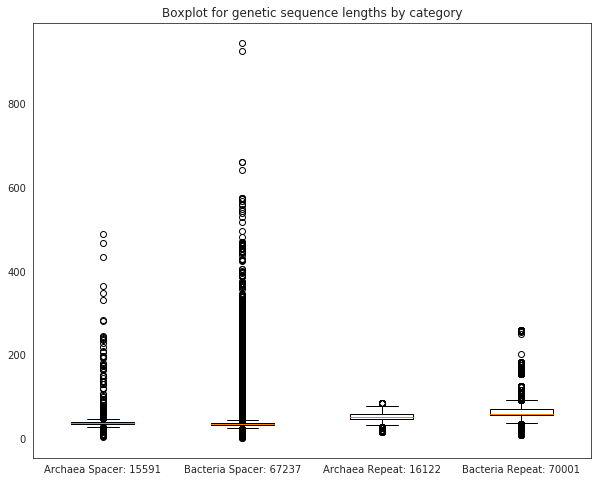

In [363]:
%matplotlib inline
import matplotlib.pyplot as plt

data_archaeaU = all_data[all_data['Label']==0]
len_archaeaU = len(data_archaeaU)
data_bacteriaU = all_data[all_data['Label']==1]
len_bacteriaU = len(data_bacteriaU)
data_archaeaG = all_data[all_data['Label']==2]
len_archaeaG = len(data_archaeaG)
data_bacteriaG = all_data[all_data['Label']==3]
len_bacteriaG = len(data_bacteriaG)

# boxplot
data_plot = [data_archaeaU['Length'],data_bacteriaU['Length'],data_archaeaG['Length'],data_bacteriaG['Length']]
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.set_title('Boxplot for genetic sequence lengths by category')
ax1.boxplot(data_plot)
plt.xticks([1,2,3,4],['Archaea Spacer: '+str(len_archaeaU),'Bacteria Spacer: '+str(len_bacteriaU),'Archaea Repeat: '+str(len_archaeaG),'Bacteria Repeat: '+str(len_bacteriaG)])
plt.show()

In [364]:
# numpy array of sequences of a fixed length

median_length = 500
# define numpy array with dimension (1,227,759 proteins, median=500 features)
all_sequence_no_dim = np.zeros(shape=(len(all_sequence_no),median_length))
# define dimension of features
no_dim_features = median_length

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in str(all_sequence_no[n])]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= median_length:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:median_length]   

(168951, 500)


In [365]:
# print(all_sequence[0])
# print(all_sequence_no[0])
print(len(all_sequence_no_dim[0]))
print(all_sequence_no_dim[0])

500
[3. 1. 3. 4. 1. 1. 3. 2. 3. 1. 4. 1. 2. 1. 4. 2. 2. 2. 1. 2. 4. 4. 4. 1.
 1. 4. 1. 4. 1. 3. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [366]:
def reproduce(seed_number):
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.keras.backend.set_session(sess)

In [367]:
from sklearn.preprocessing import MinMaxScaler
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
all_sequence_no_dim_norm = min_max_scaler.fit_transform(all_sequence_no_dim)

In [368]:
# what type of gene subpopulations exist in data? Let's do PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
Y = pca.fit_transform(all_sequence_no_dim_norm)
#Y = pca.fit_transform(all_sequence_no_dim)

# 3D PCA
pca_3D = PCA(n_components=3)
Y_3D = pca.fit_transform(all_sequence_no_dim_norm)

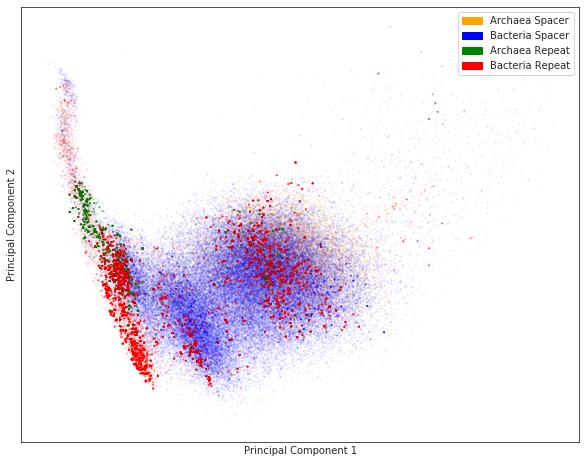

In [370]:
#label_name = {1:"Host Archaea", 2:"Host Bacteria"}
label_color_map = {0:'orange',1:'blue',2:'green',3:'red'}
label_color = [label_color_map[c] for c in all_label]

# 2D PCA plot
fig = plt.figure(figsize=(10,8))
ax = plt.scatter(Y[:,0], Y[:,1], s=1, c=label_color, alpha=0.05)

plt.xticks([])
plt.yticks([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ar_spacer_patch = mpatches.Patch(color='orange', label='Archaea Spacer')
ba_spacer_patch = mpatches.Patch(color='blue', label='Bacteria Spacer')
ar_gene_patch = mpatches.Patch(color='green', label='Archaea Repeat')
ba_gene_patch = mpatches.Patch(color='red', label='Bacteria Repeat')
plt.legend(handles=[ar_spacer_patch,ba_spacer_patch,ar_gene_patch,ba_gene_patch],loc='upper right')

plt.show()
#fig.savefig('PCA_min_features_acr_2D.pdf')

# Step 2: Create, compile, fit autoencoder model
- use Keras, a high-level neural networks API that runs on top of librares like TensorFlow.

In [371]:
#split the data in training and test sets
Y = pd.Series(all_label)

x_train, x_test, y_train_og, y_test = train_test_split(all_sequence_no_dim_norm, Y, test_size=0.01, random_state=10)
print('Training set has', x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('Test set has', x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

Training set has 167261 rows and 500 columns
Test set has 1690 rows and 500 columns


In [372]:
y_train = pd.Series(y_train_og).values

In [373]:
#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    ax1 = plt.imshow(data_norm, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax1)
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    ax2 = plt.imshow(data_dec, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax2)
    plt.title('Recondstruction', fontsize=25)
    plt.subplot(3,1,3)
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.gca().set_xticks(range(no_dim_features))
#    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
    plt.title('Residuals', fontsize=25)
    plt.show()
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss', 'Validation loss'])
    plt.show()

#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
    #label_name = {1:"Host Archaea", 2:"Host Bacteria"}
    label_color_map = {0:'orange',1:'blue',2:'green',3:'red'}
    label_color = [label_color_map[c] for c in y_train]

    ar_spacer_patch = mpatches.Patch(color='orange', label='Archaea Spacer')
    ba_spacer_patch = mpatches.Patch(color='blue', label='Bacteria Spacer')
    ar_gene_patch = mpatches.Patch(color='green', label='Archaea Repeat')
    ba_gene_patch = mpatches.Patch(color='red', label='Bacteria Repeat')
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,2], s=5, c=label_color, alpha=0.05)
    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[ar_spacer_patch,ba_spacer_patch,ar_gene_patch,ba_gene_patch],loc='upper right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

def plot_encoded_3D(x_train_encoded, y_train):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    label_color_map = {0:'orange',1:'blue',2:'green',3:'red'}
    label_color = [label_color_map[c] for c in y_train]
    
    ax.scatter(x_train_encoded[:,0], \
               x_train_encoded[:,1], \
               x_train_encoded[:,2], \
               c=label_color, alpha=0.1)

    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title("3D Embedding: ")
    pylab.show()
    return

In [374]:
reproduce(10)

#set dimensions of input and hidden layer
input_dim = no_dim_features
intermediate_1 = 30
intermediate_2 = 15
intermediate_3 = 7
latent_dim = 3

input_data = tf.keras.layers.Input(shape=(input_dim,))
#encode the input with a dense layer
encoded_1 = tf.keras.layers.Dense(intermediate_1, activation='relu')(input_data)
encoded_2 = tf.keras.layers.Dense(intermediate_2, activation='relu')(encoded_1)
encoded_3 = tf.keras.layers.Dense(intermediate_3, activation='relu')(encoded_2)
encoded_4 = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded_3)
#decode the encoded input to its reconstruction
decoded_1 = tf.keras.layers.Dense(intermediate_3, activation='relu')(encoded_4)
decoded_2 = tf.keras.layers.Dense(intermediate_2, activation='relu')(decoded_1)
decoded_3 = tf.keras.layers.Dense(intermediate_1, activation='relu')(decoded_2)
decoded_4 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded_3)

#autoencoder_2 maps the input to the output
autoencoder_4 = tf.keras.models.Model(input_data, decoded_4)

#encoder_2 maps the input to the latent representation
encoder_4 = tf.keras.models.Model(input_data, encoded_4)

#compile the model and set the desired optimizer and loss function
autoencoder_4.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_4.summary()
autoencoder_4.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 30)                15030     
_________________________________________________________________
dense_25 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 24        
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 28        
_________________________________________________________________
dense_29 (Dense)             (None, 15)                120 

167261/167261 [==============================] - 30s 177us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 77/100
167261/167261 [==============================] - 29s 173us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 78/100
167261/167261 [==============================] - 30s 180us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 79/100
167261/167261 [==============================] - 29s 175us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 80/100
167261/167261 [==============================] - 30s 180us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 81/100
167261/167261 [==============================] - 31s 188us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 82/100
167261/167261 [==============================] - 35s 211us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 83/100
167261/167261 [==============================] - 32s 193us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 84/100
167261/167261 [==============================] - 31s 187us/sample - loss: 0.0041 - val_loss: 0.0

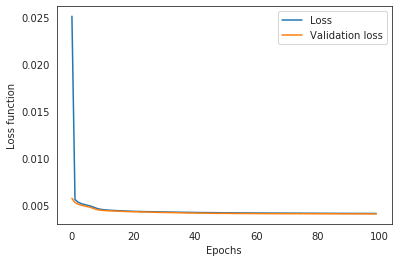

In [375]:
plot_history(autoencoder_4)

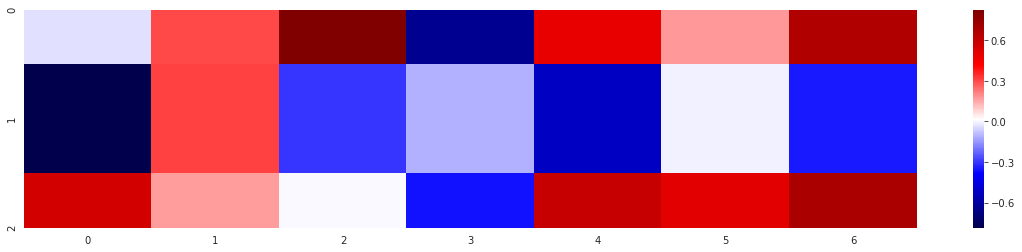

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_4.layers[5].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=weights[0], cmap='seismic')
#plt.gca().set_xticklabels(range(no_dim_features))
plt.show()

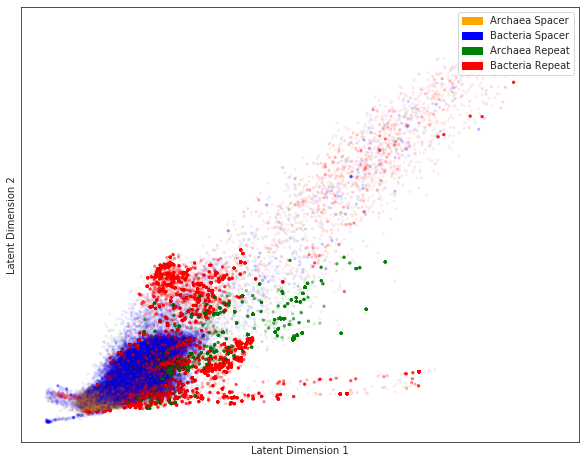

In [377]:
#encoder input into latent dimensions
x_enc_4 = encoder_4.predict(x_train, batch_size=256)
plot_encoded(x_enc_4, y_train)

W0826 18:46:32.564892 139704026509440 legend.py:1282] No handles with labels found to put in legend.


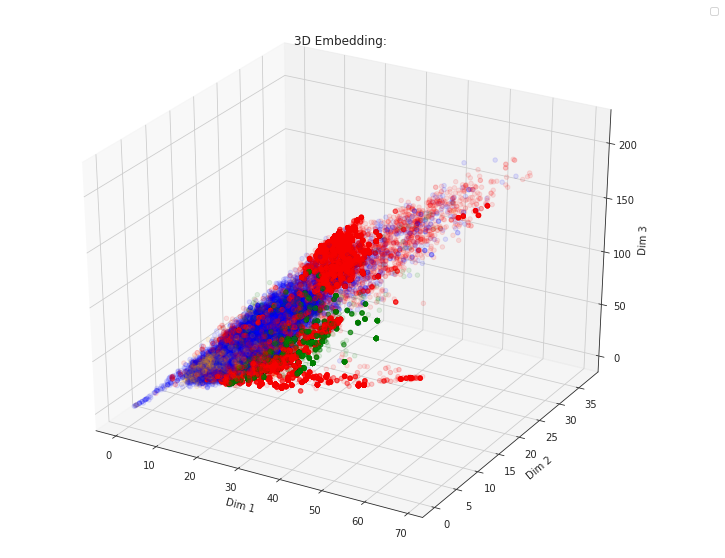

In [378]:
plot_encoded_3D(x_enc_4, y_train_og)

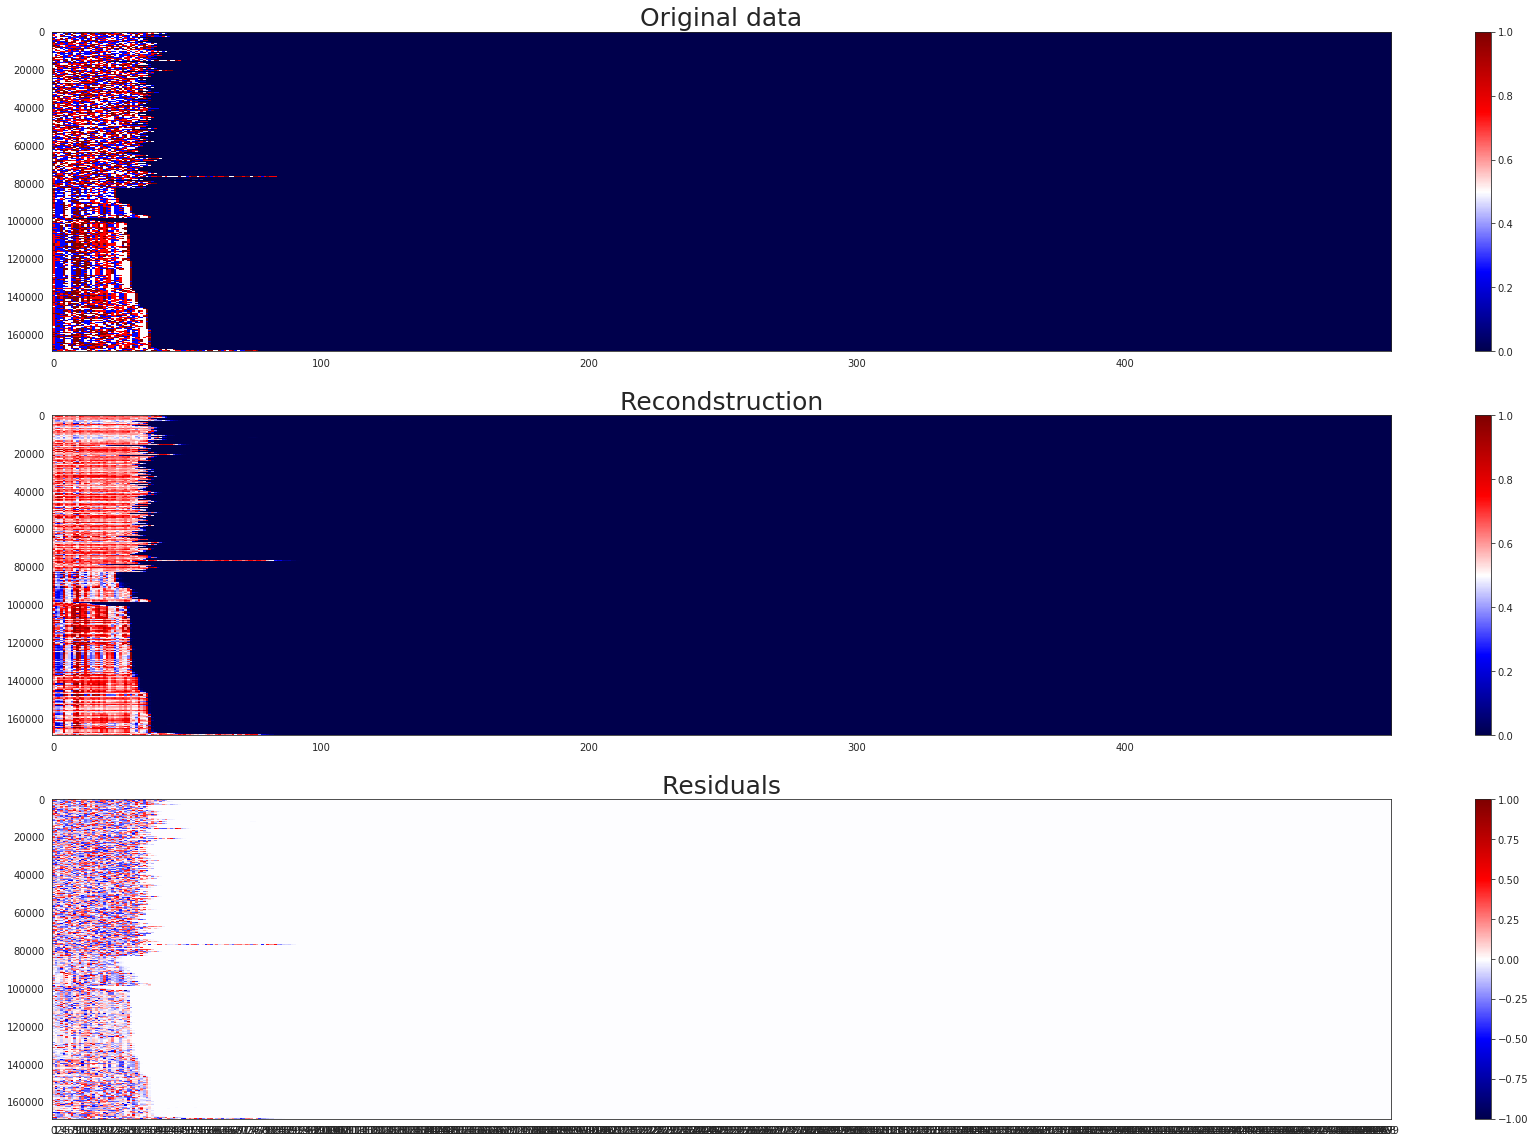

1161849.0746732298


In [379]:
#reconstruct the data
data_dec_4 = autoencoder_4.predict(all_sequence_no_dim_norm)
plot_reconstruction(all_sequence_no_dim_norm, data_dec_4)